In [63]:

import pandas as pd 
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
from datetime import datetime,timedelta
import random
from pygeocoder import Geocoder
import folium
import branca.colormap as cmp
import tqdm
#https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html#dtw-between-set-of-series
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

#Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [142]:
df_Nbh_IN_temp_Hour=pd.read_csv('E:\Data\divvy/Nbh_Hour_IN_1721_full.csv')
NBH_in_HOUR_result=pd.read_csv('E:\Data\divvy/Nbh_Hour_IN_1721_result.csv',index_col=0)
df_Nbh_OUT_temp_Hour=pd.read_csv('E:\Data\divvy/Nbh_Hour_OUT_1721_full.csv')
NBH_OUT_HOUR_result=pd.read_csv('E:\Data\divvy/Nbh_Hour_OUT_1721_result.csv',index_col=0)
df_station = pd.read_csv('E:\Data\divvy/df_station_1721_FINAL.csv',index_col=0)

In [20]:
def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.ones((n+1, m+1))
    dtw_matrix = np.inf * dtw_matrix
    # for i in tqdm.trange(n+1):
    #     for j in range(m+1):
    #         dtw_matrix[i, j] = np.inf|
    dtw_matrix[0, 0] = 0
    #return dtw_matrix
    for i in tqdm.trange(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [14]:
df_Nbh_IN_temp_Hour.head()

,Hour,1.0,1.1,2.0,2.1,2.3,2.4,3.0,3.1,3.2,...,73.1,74.0,74.1,75.0,75.2,77.0,77.1,77.2,77.3,77.4
0,2017-01-01 00:00:00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2017-01-01 01:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-01 02:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
3,2017-01-01 03:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2017-01-01 04:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
df_Nbh_IN_temp_Hour.set_index('Hour',inplace=True)

Text(0.5, 1.0, 'Natural Clusters Exist')

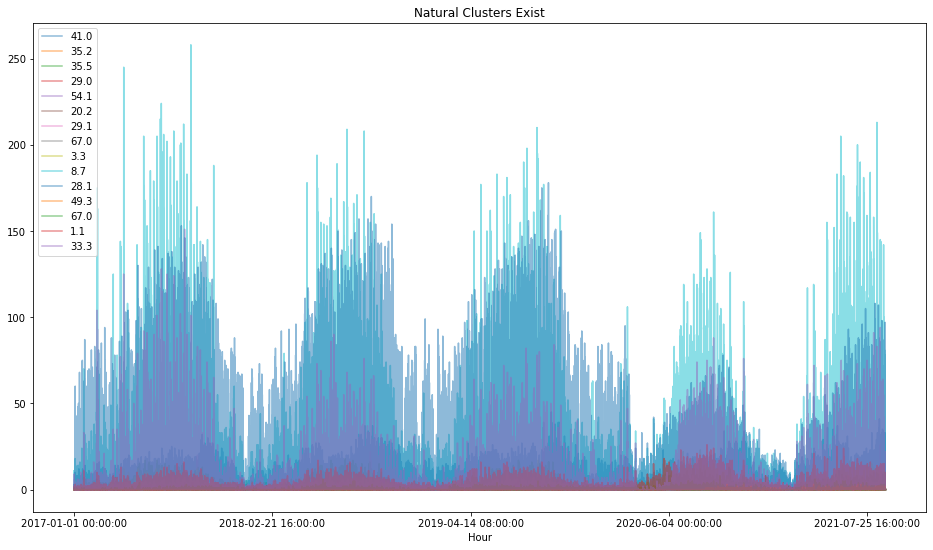

In [54]:
df_Nbh_IN_temp_Hour[random.choices(df_Nbh_IN_temp_Hour.columns,k=15)].plot(figsize=(16,9),alpha=0.5)
plt.title('Natural Clusters Exist')

<AxesSubplot:xlabel='Hour'>

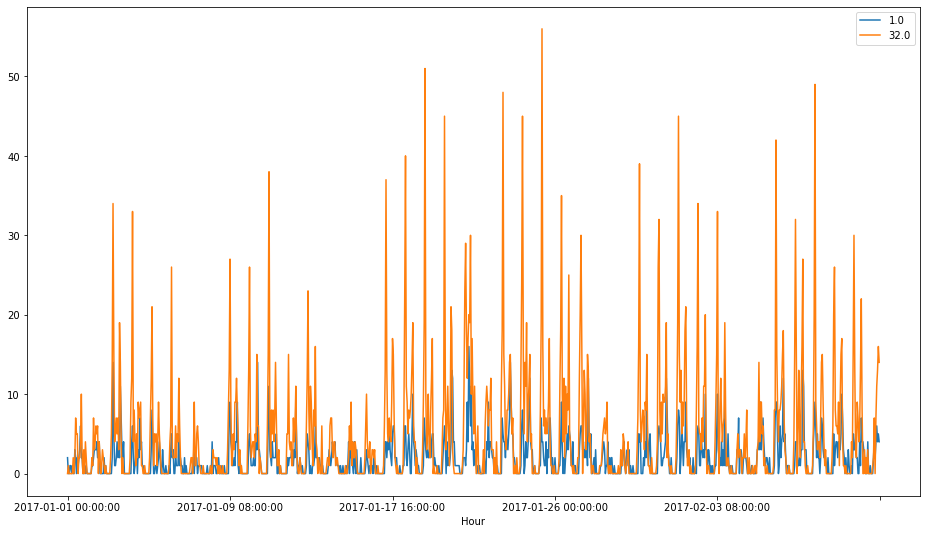

In [49]:
s1 = df_Nbh_IN_temp_Hour['1.0'][:1000]
s2 = df_Nbh_IN_temp_Hour['32.0'][:1000] 
pd.DataFrame(s1).join(s2).plot(figsize=(16,9))

In [50]:
path = dtw.warping_path(s1, s2)

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

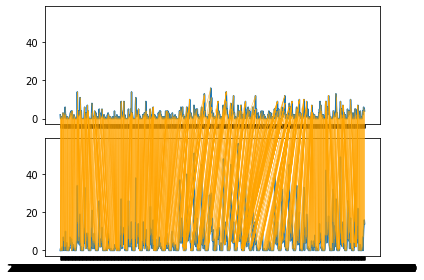

In [51]:
#plt.figure(figsize=(16,9))
dtwvis.plot_warping(s1, s2, path)#, filename="warp.png")

In [52]:
distance = dtw.distance(s1, s2)
print(distance)

172.043599125338


### Clustering Using Ecludiean Distance

In [65]:
df_subset = df_Nbh_IN_temp_Hour[random.choices(df_Nbh_IN_temp_Hour.columns,k=15)]
kmeans = KMeans(n_clusters=2).fit(df_Nbh_IN_temp_Hour)

In [66]:
pd.DataFrame(kmeans.labels_).value_counts() 

0    32430
1     8484
dtype: int64

## Evaluation: Silhouette Score
https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c#:~:text=Silhouette%20Coefficient%20or%20silhouette%20score%20is%20a%20metric%20used%20to,each%20other%20and%20clearly%20distinguished.

In [86]:
res_dct = {'n_cluster':[],'silhouette_score':[]}
for n in tqdm.trange(2,20):
    kmeans = KMeans(n_clusters=n).fit(df_Nbh_IN_temp_Hour.T)
    res_dct['n_cluster'].append(n)
    res_dct['silhouette_score'].append(silhouette_score(df_Nbh_IN_temp_Hour.T, kmeans.labels_))

100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


In [138]:
pd.DataFrame(res_dct)

,n_cluster,silhouette_score
0,2,0.788966
1,3,0.770919
2,4,0.615662
3,5,0.620286
4,6,0.619503
5,7,0.616161
6,8,0.554243
7,9,0.616986
8,10,0.537681
9,11,0.563643


<Figure size 1152x648 with 0 Axes>

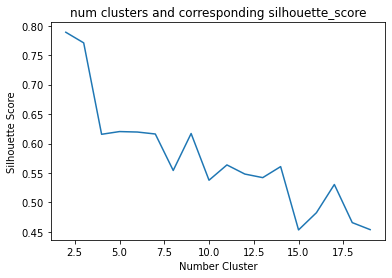

<Figure size 1152x648 with 0 Axes>

In [89]:
plt.plot(res_dct['n_cluster'],res_dct['silhouette_score'])
plt.title('num clusters and corresponding silhouette_score')
plt.xlabel('Number Cluster')
plt.ylabel('Silhouette Score')
plt.figure(figsize=(16,9))

In [90]:
#Looks like 2,3,9 clusters are the best number of clusters
kmeans_2 = KMeans(n_clusters=2).fit(df_Nbh_IN_temp_Hour.T)
kmeans_3 = KMeans(n_clusters=3).fit(df_Nbh_IN_temp_Hour.T)
kmeans_9 = KMeans(n_clusters=9).fit(df_Nbh_IN_temp_Hour.T)

In [97]:
df_clustering = pd.DataFrame(index = df_Nbh_IN_temp_Hour.columns)

In [100]:
df_clustering['kmeans_2'] = kmeans_2.labels_
df_clustering['kmeans_3'] = kmeans_3.labels_
df_clustering['kmeans_9'] = kmeans_9.labels_

In [110]:
df_station.Nbh_id   = df_station.Nbh_id.apply(lambda x:str(x))

In [112]:
df_station_kmeans = df_station.merge(df_clustering.reset_index().rename({'index':'Nbh_id'},axis=1),on='Nbh_id',how='left')

In [305]:
def Geo_Viz(df_station,col,categorical = False,
            color_palette = 'rocket',colormap = None, color_map_caption='Color Scale for Map',
            lower_scale = 'min', upper_scale = '75%', 
            Init_COORDINATES = (41.864073, -87.706819)):
    if colormap is None:
        if categorical:
            colors = ["red", "blue", "green", "purple", "orange", "darkred",
             "darkblue", "darkgreen", "cadetblue", "darkpurple", "pink", "gray", "black"]
            colors_subset = random.choices(colors,k=len(df_station[col].unique()))
            print(colors_subset)
            color_dct = {i:j for i,j in zip(df_station[col].unique(),colors_subset)}
            colormap = lambda x: color_dct[x]
        else:
            colormap = cmp.StepColormap(
            eval(sns.color_palette(color_palette).as_hex().__str__()),
            vmin=df_station[col].describe()[lower_scale], vmax=df_station[col].describe()[upper_scale],
            #for change in the colors, not used fr linear
            caption= color_map_caption    #Caption for Color scale or Legend
            ) 
    # for speed purposes
    #MAX_RECORDS = 100

    # create empty map zoomed in on San Francisco
    map = folium.Map(location=Init_COORDINATES, zoom_start=11)
    
    # add a marker for every record in the filtered data
    for idx,row in df_station.iterrows():
        folium.Circle(
            location = (row['lat'],row['lng']),
            radius = 2,
            color = colormap(row[col])
            ).add_to(map)
    if not categorical:
        map.add_child(colormap)
    return map

In [114]:
df_station_kmeans.head()

,station_name,lng,lat,Docks in Service,Nbh_id,com_id,date_begin,date_end,kmeans_9,kmeans_2,kmeans_3
0,2112 W Peterson Ave,-87.683593,41.991181,11.0,2.4,2.0,NaN,NaN,1.0,1.0,0.0
1,351,-87.606611,41.803023,15.0,39.1,39.0,NaN,NaN,1.0,1.0,0.0
2,63rd St Beach,-87.576167,41.780997,15.0,43.1,43.0,2017-01-21,NaN,1.0,1.0,0.0
3,900 W Harrison St,-87.649806,41.874765,17.0,28.2,28.0,NaN,NaN,3.0,0.0,1.0
4,Aberdeen St & Jackson Blvd,-87.654801,41.877725,19.0,28.2,28.0,NaN,NaN,3.0,0.0,1.0


In [123]:
df_station_kmeans.kmeans_3.value_counts()

0.0    666
2.0     96
1.0     69
Name: kmeans_3, dtype: int64

In [137]:
Geo_Viz(df_station_kmeans.dropna(subset = ['lng']),'kmeans_2',categorical=True)

In [133]:
Geo_Viz(df_station_kmeans.dropna(subset = ['lng']),'kmeans_3',categorical=True)

In [134]:
Geo_Viz(df_station_kmeans.dropna(subset = ['lng']),'kmeans_9',categorical=True)

In [139]:
df_station_kmeans.to_csv('E:\Data\divvy/df_station_1721_FINAL_Clusterd.csv')

In [148]:
NBH_in_HOUR_result.rename({
    'stations':'Nbh_id',
    'ADI':'Nbh_Hourly_IN_ADI',
    'CV2':'Nbh_Hourly_IN_CV2',
    'forecastability':'Nbh_Hourly_IN_forecastability'
},axis=1,inplace=True)

In [149]:
NBH_OUT_HOUR_result.rename({
    'stations':'Nbh_id',
    'ADI':'Nbh_Hourly_OUT_ADI',
    'CV2':'Nbh_Hourly_OUT_CV2',
    'forecastability':'Nbh_Hourly_OUT_forecastability'
},axis=1,inplace=True)

In [154]:
df_station_kmeans.Nbh_id = df_station_kmeans.Nbh_id .apply(lambda x:float(x))

In [157]:
df_station_kmeans_InOut_F = df_station_kmeans.merge(NBH_in_HOUR_result,on='Nbh_id',how='left').merge(NBH_OUT_HOUR_result,on='Nbh_id',how='left')

In [158]:
df_station_kmeans_InOut_F.head()

,station_name,lng,lat,Docks in Service,Nbh_id,com_id,date_begin,date_end,kmeans_9,kmeans_2,kmeans_3,Nbh_Hourly_IN_ADI,Nbh_Hourly_IN_CV2,Nbh_Hourly_IN_forecastability,Nbh_Hourly_OUT_ADI,Nbh_Hourly_OUT_CV2,Nbh_Hourly_OUT_forecastability
0,2112 W Peterson Ave,-87.683593,41.991181,11.0,2.4,2.0,NaN,NaN,1.0,1.0,0.0,3.932148,4.351138,Lumpy,3.921219,4.256763,Lumpy
1,351,-87.606611,41.803023,15.0,39.1,39.0,NaN,NaN,1.0,1.0,0.0,2.972537,3.708315,Lumpy,2.916387,3.609666,Lumpy
2,63rd St Beach,-87.576167,41.780997,15.0,43.1,43.0,2017-01-21,NaN,1.0,1.0,0.0,3.918966,5.451975,Lumpy,3.983836,5.648548,Lumpy
3,900 W Harrison St,-87.649806,41.874765,17.0,28.2,28.0,NaN,NaN,3.0,0.0,1.0,1.138778,2.167557,Erratic,1.123980,2.197712,Erratic
4,Aberdeen St & Jackson Blvd,-87.654801,41.877725,19.0,28.2,28.0,NaN,NaN,3.0,0.0,1.0,1.138778,2.167557,Erratic,1.123980,2.197712,Erratic


In [162]:
pd.DataFrame(df_station_kmeans_InOut_F.groupby(['Nbh_Hourly_IN_forecastability','Nbh_Hourly_OUT_forecastability']).count().station_name)

station_name
Nbh_Hourly_IN_forecastability Nbh_Hourly_OUT_forecastability              
Erratic                       Erratic                                  195
                              Lumpy                                     10
Lumpy                         Erratic                                    9
                              Lumpy                                    617

In [174]:
df_station_erratic = df_station_kmeans_InOut_F.query("Nbh_Hourly_IN_forecastability != 'Lumpy' & Nbh_Hourly_OUT_forecastability != 'Lumpy'")

In [178]:
df_station_kmeans_InOut_F

,station_name,lng,lat,Docks in Service,Nbh_id,com_id,date_begin,date_end,kmeans_9,kmeans_2,kmeans_3,Nbh_Hourly_IN_ADI,Nbh_Hourly_IN_CV2,Nbh_Hourly_IN_forecastability,Nbh_Hourly_OUT_ADI,Nbh_Hourly_OUT_CV2,Nbh_Hourly_OUT_forecastability
0,2112 W Peterson Ave,-87.683593,41.991181,11.0,2.4,2.0,NaN,NaN,1.0,1.0,0.0,3.932148,4.351138,Lumpy,3.921219,4.256763,Lumpy
1,351,-87.606611,41.803023,15.0,39.1,39.0,NaN,NaN,1.0,1.0,0.0,2.972537,3.708315,Lumpy,2.916387,3.609666,Lumpy
2,63rd St Beach,-87.576167,41.780997,15.0,43.1,43.0,2017-01-21,NaN,1.0,1.0,0.0,3.918966,5.451975,Lumpy,3.983836,5.648548,Lumpy
3,900 W Harrison St,-87.649806,41.874765,17.0,28.2,28.0,NaN,NaN,3.0,0.0,1.0,1.138778,2.167557,Erratic,1.123980,2.197712,Erratic
4,Aberdeen St & Jackson Blvd,-87.654801,41.877725,19.0,28.2,28.0,NaN,NaN,3.0,0.0,1.0,1.138778,2.167557,Erratic,1.123980,2.197712,Erratic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,Woodlawn Ave & 55th St,-87.596476,41.795276,15.0,41.0,41.0,NaN,NaN,6.0,1.0,0.0,1.339028,1.243194,Lumpy,1.357961,1.417486,Lumpy
847,Woodlawn Ave & 75th St,-87.595769,41.759184,11.0,44.1,44.0,2017-01-21,NaN,1.0,1.0,0.0,17.336441,19.410097,Lumpy,17.681072,19.985339,Lumpy
848,Woodlawn Ave & Lake Park Ave,-87.597008,41.814090,13.0,39.1,39.0,NaN,NaN,1.0,1.0,0.0,2.972537,3.708315,Lumpy,2.916387,3.609666,Lumpy
849,Yates Blvd & 75th St,-87.566435,41.758763,11.0,43.0,43.0,2017-03-30,NaN,1.0,1.0,0.0,5.849035,7.263503,Lumpy,5.887754,7.508382,Lumpy


In [193]:
Nbh_erratic = [str(i) for i in df_station_erratic.dropna(subset ='Nbh_id').Nbh_id.unique()]

In [195]:
df_Nbh_IN_Hour_Erratic = df_Nbh_IN_temp_Hour[list(Nbh_erratic)]

In [198]:
res_dct = {'n_cluster':[],'silhouette_score':[]}
for n in tqdm.trange(2,10):
    kmeans = KMeans(n_clusters=n).fit(df_Nbh_IN_Hour_Erratic.T)
    res_dct['n_cluster'].append(n)
    res_dct['silhouette_score'].append(silhouette_score(df_Nbh_IN_Hour_Erratic.T, kmeans.labels_))

100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


<Figure size 1152x648 with 0 Axes>

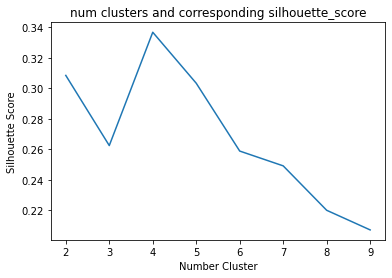

<Figure size 1152x648 with 0 Axes>

In [199]:
plt.plot(res_dct['n_cluster'],res_dct['silhouette_score'])
plt.title('num clusters and corresponding silhouette_score')
plt.xlabel('Number Cluster')
plt.ylabel('Silhouette Score')
plt.figure(figsize=(16,9))

In [200]:
pd.DataFrame(res_dct)

,n_cluster,silhouette_score
0,2,0.308405
1,3,0.262425
2,4,0.336707
3,5,0.303278
4,6,0.258822
5,7,0.249117
6,8,0.219996
7,9,0.207125


In [206]:
kmeans_e_2 = KMeans(n_clusters=2).fit(df_Nbh_IN_Hour_Erratic.T)
kmeans_e_4 = KMeans(n_clusters=4).fit(df_Nbh_IN_Hour_Erratic.T)

In [269]:
df_clustering_e = pd.DataFrame(index = df_Nbh_IN_Hour_Erratic.columns)
df_clustering_e['Erratic_Kmeans2'] = kmeans_e_2.labels_
df_clustering_e['Erratic_Kmeans4'] = kmeans_e_4.labels_
df_clustering_e = df_clustering_e.reset_index().rename({'index':'Nbh_id'},axis=1)

In [270]:
df_station_kmeans_InOut_F.Nbh_id = df_station_kmeans_InOut_F.Nbh_id.apply(lambda x:str(x))

In [283]:
df_station_kmeans_InOut_F_Ekmeans = df_station_kmeans_InOut_F.merge(
    df_clustering_e , on = 'Nbh_id', how = 'left'
)

In [289]:
df_station_kmeans_InOut_F_Ekmeans.dropna(subset=['lng','Erratic_Kmeans2']).head()

,station_name,lng,lat,Docks in Service,Nbh_id,com_id,date_begin,date_end,kmeans_9,kmeans_2,kmeans_3,Nbh_Hourly_IN_ADI,Nbh_Hourly_IN_CV2,Nbh_Hourly_IN_forecastability,Nbh_Hourly_OUT_ADI,Nbh_Hourly_OUT_CV2,Nbh_Hourly_OUT_forecastability,Erratic_Kmeans2,Erratic_Kmeans4
3,900 W Harrison St,-87.649806,41.874765,17.0,28.2,28.0,NaN,NaN,3.0,0.0,1.0,1.138778,2.167557,Erratic,1.123980,2.197712,Erratic,1.0,3.0
4,Aberdeen St & Jackson Blvd,-87.654801,41.877725,19.0,28.2,28.0,NaN,NaN,3.0,0.0,1.0,1.138778,2.167557,Erratic,1.123980,2.197712,Erratic,1.0,3.0
5,Aberdeen St & Monroe St,-87.655530,41.880412,17.0,28.2,28.0,NaN,NaN,3.0,0.0,1.0,1.138778,2.167557,Erratic,1.123980,2.197712,Erratic,1.0,3.0
56,Benson Ave & Church St,-87.683494,42.048206,15.0,1.0,1.0,NaN,NaN,6.0,1.0,0.0,1.288955,1.473322,Erratic,1.311977,1.519341,Erratic,0.0,1.0
62,Bosworth Ave & Howard St,-87.669556,42.019530,13.0,1.0,1.0,NaN,NaN,6.0,1.0,0.0,1.288955,1.473322,Erratic,1.311977,1.519341,Erratic,0.0,1.0


In [300]:
Geo_Viz(df_station_kmeans_InOut_F_Ekmeans.dropna(subset=['lng','Erratic_Kmeans2']),'Erratic_Kmeans2',categorical=True)

['darkgreen', 'purple']


In [307]:
Geo_Viz(df_station_kmeans_InOut_F_Ekmeans.dropna(subset=['lng','Erratic_Kmeans2']),'Erratic_Kmeans4',categorical=True)

['purple', 'red', 'darkblue', 'black']


In [309]:
df_station_kmeans_InOut_F_Ekmeans.to_csv('E:\Data\divvy/df_station_1721_FINAL_Erratic.csv')

### Visualizing the K4 Clusters

3.0


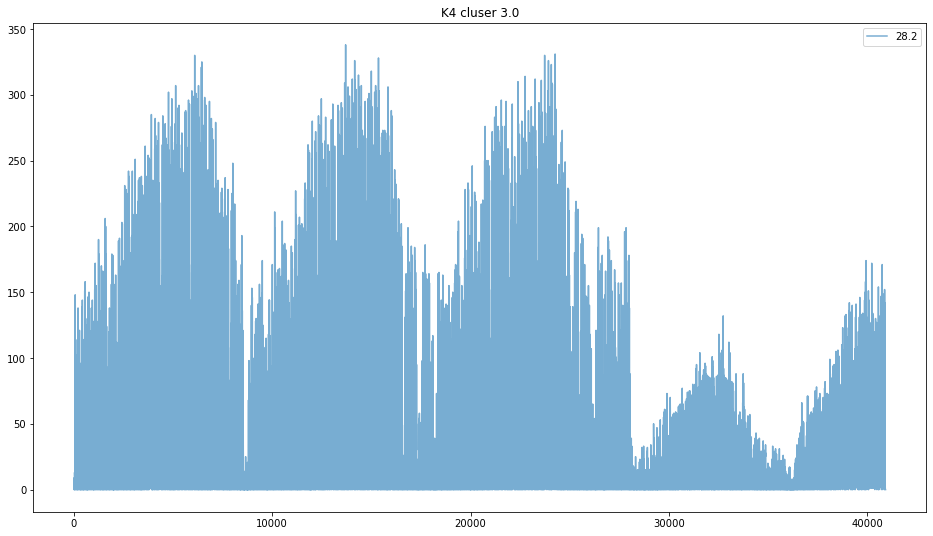

1.0


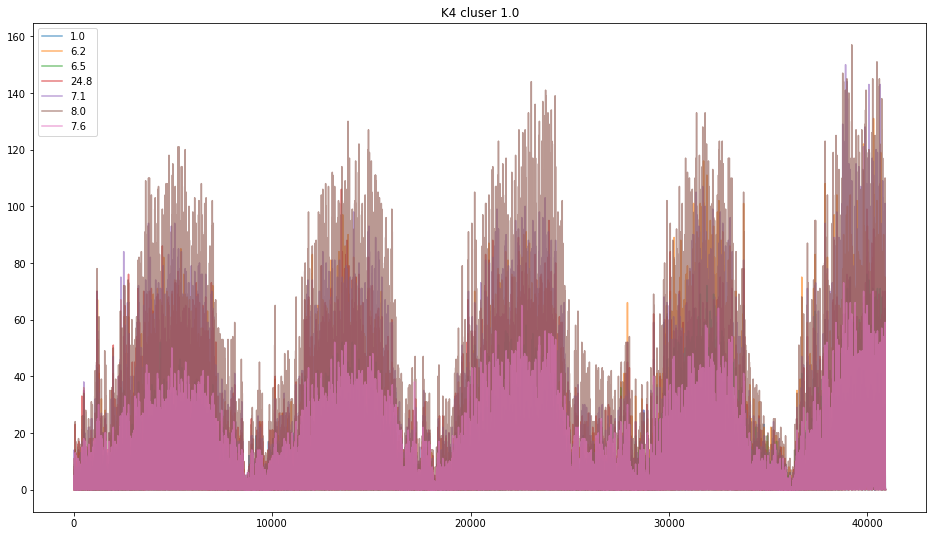

2.0


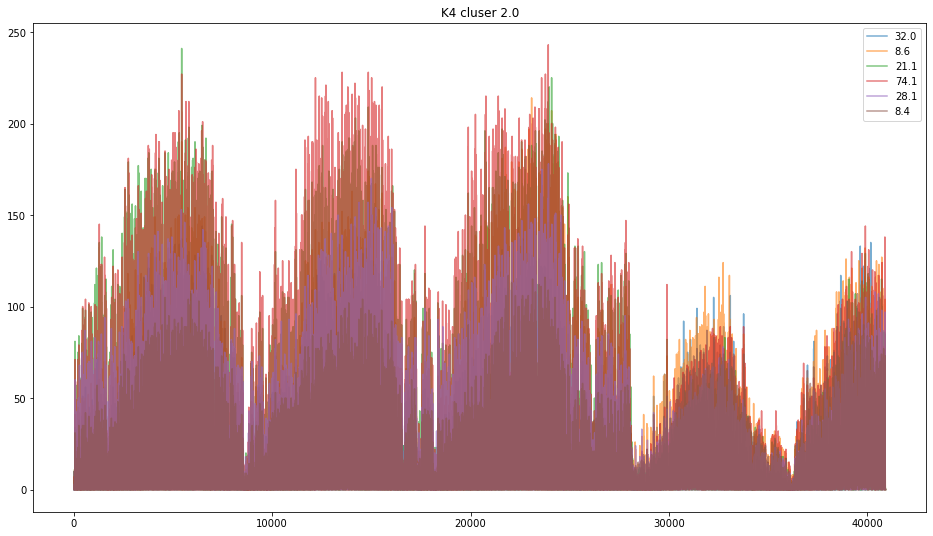

0.0


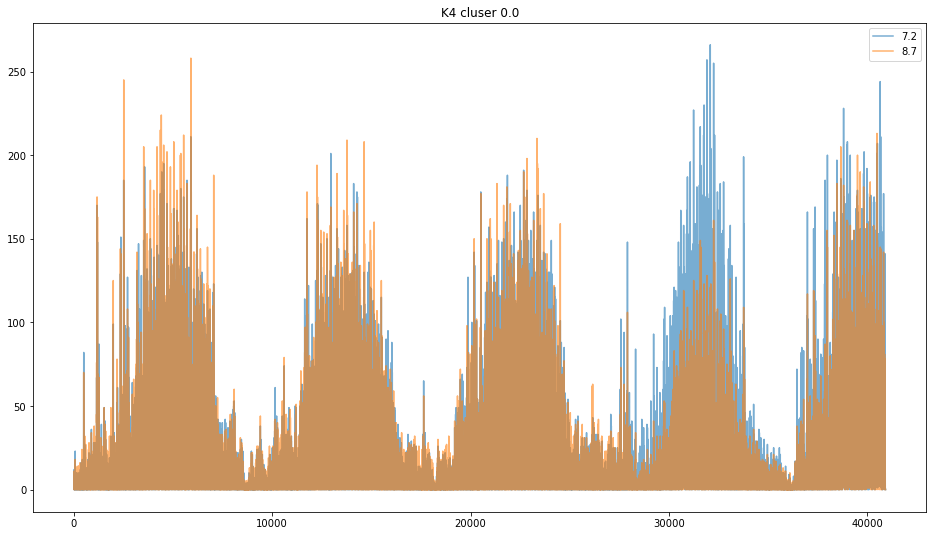

In [323]:
for cluster in df_station_kmeans_InOut_F_Ekmeans.Erratic_Kmeans4.dropna().unique():
    print(cluster)
    Nbh_id_oi =df_station_kmeans_InOut_F_Ekmeans.query(f'Erratic_Kmeans4 == {cluster}').Nbh_id.unique()
    df_Nbh_IN_Hour_Erratic[Nbh_id_oi].plot(figsize =(16,9),alpha=0.6)
    plt.title(f'K4 cluser {cluster}')
    plt.show()

1.0


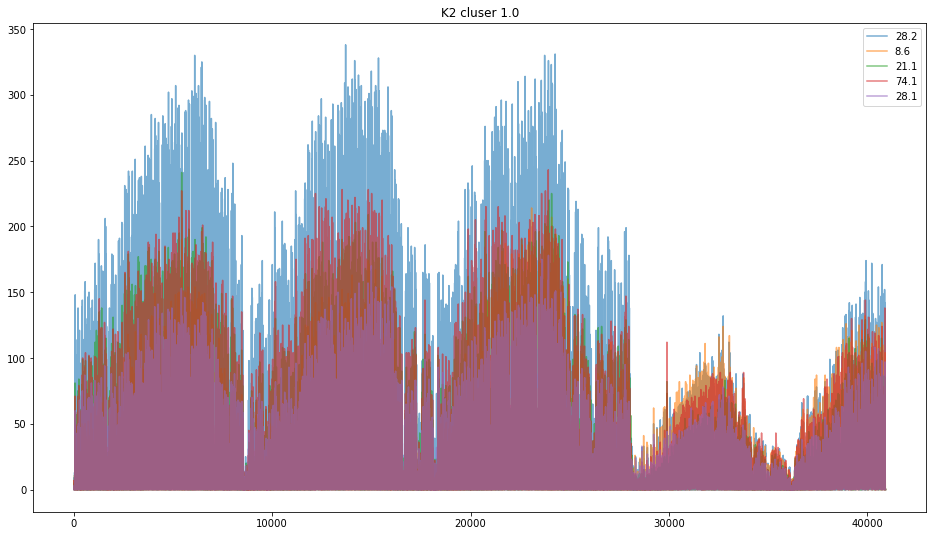

0.0


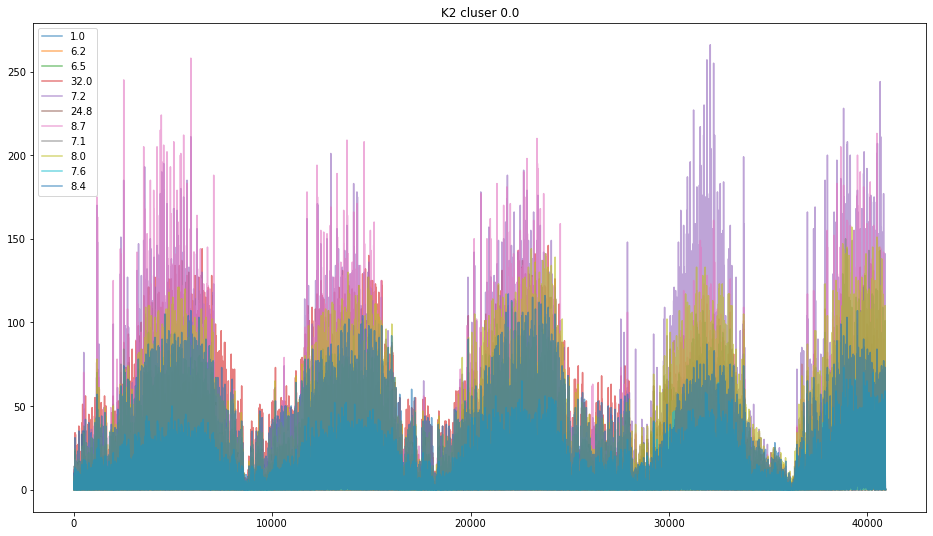

In [324]:
for cluster in df_station_kmeans_InOut_F_Ekmeans.Erratic_Kmeans2.dropna().unique():
    print(cluster)
    Nbh_id_oi =df_station_kmeans_InOut_F_Ekmeans.query(f'Erratic_Kmeans2 == {cluster}').Nbh_id.unique()
    df_Nbh_IN_Hour_Erratic[Nbh_id_oi].plot(figsize =(16,9),alpha=0.6)
    plt.title(f'K2 cluser {cluster}')
    plt.show()